In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import ast
from itertools import chain
from collections import Counter
pd.set_option('display.max_columns', None)
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GridSearchCV
import keras_tuner as kt
tf.random.set_seed(50)
np.random.seed(50)

df = pd.read_csv("data/full_set.csv")

c:\Users\artkr\anaconda3\New folder\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
TARGET_CLASS = "CHM2210"

# converts strings to arrays
df['Classes'] = df['Classes'].apply(ast.literal_eval)
df['Semester Grades'] = df['Semester Grades'].apply(ast.literal_eval)
df['Semester Points'] = df['Semester Points'].apply(ast.literal_eval)
df['CRN'] = df['CRN'].apply(ast.literal_eval)

# find all people who took class
Pidms_with_TARGET_CLASS = df[df['Classes'].apply(lambda x: TARGET_CLASS in x)]['Pidm'].unique()
df = df[df['Pidm'].isin(Pidms_with_TARGET_CLASS)]
df = df[['Pidm', 'Semester', 'HS GPA', 'Converted_SAT', 'Semester Points', 'Semester Grades', 'CRN', 'Classes']]
df.head(4)

# Find the first semester with TARGET_CLASS for each student
def find_first_semester(student_df):
    chm2210_row = student_df[student_df['Classes'].apply(lambda x: TARGET_CLASS in x)]
    if not chm2210_row.empty:
        return chm2210_row['Semester'].min()
    return None

first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename('Target_Semester')
df = df.merge(first_semester, on='Pidm')

# filter all semesters after student took TARGET_CLASS
filtered_df = df[df['Semester'] <= df['Target_Semester']]

# find grades/points for TARGET_CLASS and output it to a new column
def find_class_grades(student_df):
    for _, row in student_df.iterrows():
        if TARGET_CLASS in row['Classes']:
            index = row['Classes'].index(TARGET_CLASS)
            return row['Semester Points'][index], row['Semester Grades'][index]
    return None, None

class_grades = filtered_df.groupby('Pidm').apply(lambda x: find_class_grades(x)).apply(pd.Series)
class_grades.columns = ['Target_Points', 'Target_Grade']

final_df = filtered_df.merge(class_grades, on='Pidm')

# filter out these grades
final_df = final_df[~final_df['Target_Grade'].isin(['WE', 'IF', 'W', 'WC'])]


final_df = final_df[final_df['Semester'] < final_df['Target_Semester']]

groupped_df = final_df.groupby('Pidm').agg({
    "HS GPA": 'first',
    'Converted_SAT': 'first',
    'Semester Grades': lambda x: sum(x, []),
    'Semester Points': lambda x: sum(x, []),
    'Classes': lambda x: sum(x, []),
    'CRN': lambda x: sum(x, []),
    'Target_Grade': 'first',
    'Target_Points': 'first',
}).reset_index()

all_classes = sorted(set(chain.from_iterable(groupped_df['Classes'])))

def create_one_hot(classes, points, all_classes):
    one_hot_vector = [-1] * len(all_classes)
    for class_name, point in zip(classes, points):
        if class_name in all_classes:
            one_hot_vector[all_classes.index(class_name)] = point
    return one_hot_vector

groupped_df['One_Hot_Classes'] = groupped_df.apply(
    lambda row: create_one_hot(row['Classes'], row['Semester Points'], all_classes), axis=1
)

one_hot_df = pd.DataFrame(groupped_df['One_Hot_Classes'].tolist(), columns=all_classes, index=groupped_df['Pidm'])

In [3]:
from sklearn.model_selection import train_test_split

train, testing_data = train_test_split(one_hot_df, test_size=0.2, random_state=50)
dev, test = train_test_split(testing_data, test_size=0.5, random_state=50)

train_set = one_hot_df[one_hot_df.index.isin(train.index)]
dev_set = one_hot_df[one_hot_df.index.isin(dev.index)]
test_set = one_hot_df[one_hot_df.index.isin(test.index)]
columns_to_remove = []
for column in train_set.columns:
    value_counts = train_set[column].value_counts()
    max_count = value_counts.max()
    non_max_count = value_counts.sum() - max_count
    
    if non_max_count <= 20:
        columns_to_remove.append(column)
        
train_set = train_set.drop(columns=columns_to_remove)
dev_set = dev_set.drop(columns=columns_to_remove)
test_set = test_set.drop(columns=columns_to_remove)

print(train_set.shape, dev_set.shape, test_set.shape)

(9424, 355) (1178, 355) (1179, 355)


In [4]:
# Create pass/fail column
def categorize_grade(grade):
    fail_grades = ['F', 'IF', 'W', 'D-', 'F', 'D+', 'D#', 'D+', 'F#', 'D', 'D', 'D-', 'U', 'W', 
                   'F*', 'D*', 'CF', 'I', 'FF', 'Z', 'W*', 'F+', 'F-', 'F#', 'F*', 'D-*', 'IF', 
                   'IF*', 'D+*', 'CIF', 'Z*', 'IU', 'M', 'CI', 'MU', 'U*', 'ID', 'IB', 'IU*', 
                   'IS', 'CW']
    
    # Categorize the grade into one of the four classes
    if grade in fail_grades:
        return 'Fail'
    elif grade.startswith('A'):
        return 'A class'
    elif grade.startswith('B'):
        return 'B class'
    elif grade.startswith('C'):
        return 'C class'
    else:
        return 'Fail'  # Default to Fail if grade doesn't match known categories


#Add columns fro grouped_df
groupped_df_filtered = groupped_df[groupped_df['Pidm'].isin(train_set.index)]
add_columns = ['HS GPA', 'Converted_SAT', 'Target_Grade']
groupped_df_filtered.set_index('Pidm', inplace=True)
train_set = train_set.join(groupped_df_filtered[add_columns], )

groupped_df_filtered = groupped_df[groupped_df['Pidm'].isin(dev_set.index)]
add_columns = ['HS GPA', 'Converted_SAT', 'Target_Grade']
groupped_df_filtered.set_index('Pidm', inplace=True)
dev_set = dev_set.join(groupped_df_filtered[add_columns], )

# Apply the categorization function
train_set['grade_category'] = train_set['Target_Grade'].apply(categorize_grade)
dev_set['grade_category'] = dev_set['Target_Grade'].apply(categorize_grade)

# Create one-hot encoded columns
train_set = pd.get_dummies(train_set, columns=['grade_category'])
dev_set = pd.get_dummies(dev_set, columns=['grade_category'])

# Ensure that all one-hot encoding columns are present
for col in ['grade_category_A class', 'grade_category_B class', 'grade_category_C class', 'grade_category_Fail']:
    if col not in train_set:
        train_set[col] = 0
    if col not in dev_set:
        dev_set[col] = 0

# # Drop irrelevant columns
X = train_set.drop(columns=['grade_category_A class', 'grade_category_B class', 'grade_category_C class', 'grade_category_Fail', 'Target_Grade'])
X_dev = dev_set.drop(columns=['grade_category_A class', 'grade_category_B class', 'grade_category_C class', 'grade_category_Fail', 'Target_Grade'])

# Convert all remaining object columns to numeric
# X = X.apply(pd.to_numeric, errors='coerce')

In [5]:
# Drop rows with missing values
X = X.dropna()
X_dev = X_dev.dropna()
X = X.astype('float32')
X_dev = X_dev.astype('float32')

# Extract the target variable (pass/fail)
y = train_set.loc[X.index, ['grade_category_A class', 'grade_category_B class', 'grade_category_C class', 'grade_category_Fail']].values.astype('float32')
y_dev = dev_set.loc[X_dev.index, ['grade_category_A class', 'grade_category_B class', 'grade_category_C class', 'grade_category_Fail']].values.astype('float32')

### 2 layer model

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(357,)),  # Input layer
    tf.keras.layers.Dense(256, activation='relu'),  # Hidden layer 1
    tf.keras.layers.Dropout(0.0),  # Dropout layer to reduce overfitting
    tf.keras.layers.Dense(256, activation='relu'),  # Hidden layer 2
    tf.keras.layers.Dense(4, activation='softmax')  # Output layer for 4-class classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

checkpoint = ModelCheckpoint('multiclass_mlp_2ldropout.h5', 
                             monitor='val_categorical_accuracy',  # Monitor validation accuracy
                             save_best_only=True, 
                             mode='max', 
                             verbose=2)

# Train the model with the checkpoint callback
history = model.fit(X, y, 
                    validation_split=0.2,
                    epochs=70, 
                    batch_size=32, 
                    callbacks=[checkpoint])

Epoch 1/70
228/236 [===========================>..] - ETA: 0s - loss: 6.7764 - categorical_accuracy: 0.2926
Epoch 1: val_categorical_accuracy improved from -inf to 0.40318, saving model to multiclass_mlp_2ldropout.h5
236/236 [==============================] - 1s 4ms/step - loss: 6.6497 - categorical_accuracy: 0.2941 - val_loss: 2.9912 - val_categorical_accuracy: 0.4032
Epoch 2/70
236/236 [==============================] - ETA: 0s - loss: 2.9948 - categorical_accuracy: 0.3187
Epoch 2: val_categorical_accuracy improved from 0.40318 to 0.41698, saving model to multiclass_mlp_2ldropout.h5
236/236 [==============================] - 1s 2ms/step - loss: 2.9948 - categorical_accuracy: 0.3187 - val_loss: 1.9351 - val_categorical_accuracy: 0.4170
Epoch 3/70
214/236 [==========================>...] - ETA: 0s - loss: 2.5668 - categorical_accuracy: 0.3236
Epoch 3: val_categorical_accuracy did not improve from 0.41698
236/236 [==============================] - 0s 2ms/step - loss: 2.5796 - categorica

37/37 [==============================] - 0s 1ms/step - loss: 1.1688 - categorical_accuracy: 0.4677
Loss: 1.1688, Accuracy: 0.4677
37/37 [==============================] - 0s 942us/step
              precision    recall  f1-score   support

     A class       0.72      0.56      0.63       399
     B class       0.37      0.54      0.44       347
     C class       0.39      0.41      0.40       278
        Fail       0.39      0.18      0.25       154

    accuracy                           0.47      1178
   macro avg       0.47      0.42      0.43      1178
weighted avg       0.49      0.47      0.47      1178



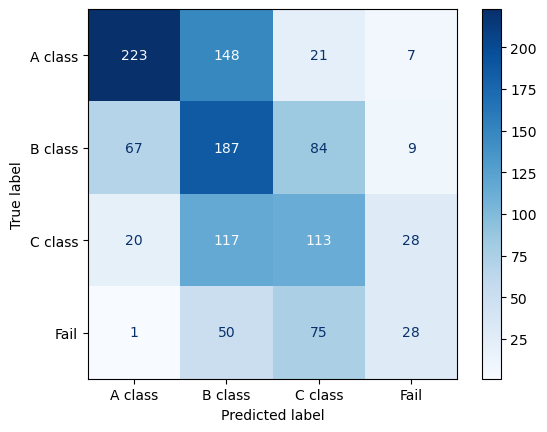

In [29]:
best_model = load_model('multiclass_mlp_2ldropout.h5')

loss, accuracy = model.evaluate(X_dev, y_dev, batch_size=32)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# Predict class probabilities
y_pred_probs = model.predict(X_dev)

# Convert probabilities to predicted class labels (choose the class with highest probability)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded y_dev to class labels for comparison
y_dev_labels = np.argmax(y_dev, axis=1)

# Print classification report for multi-class classification
print(classification_report(y_dev_labels, y_pred, target_names=["A class", "B class", "C class", "Fail"]))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_dev_labels, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["A class", "B class", "C class", "Fail"])
disp.plot(cmap='Blues')

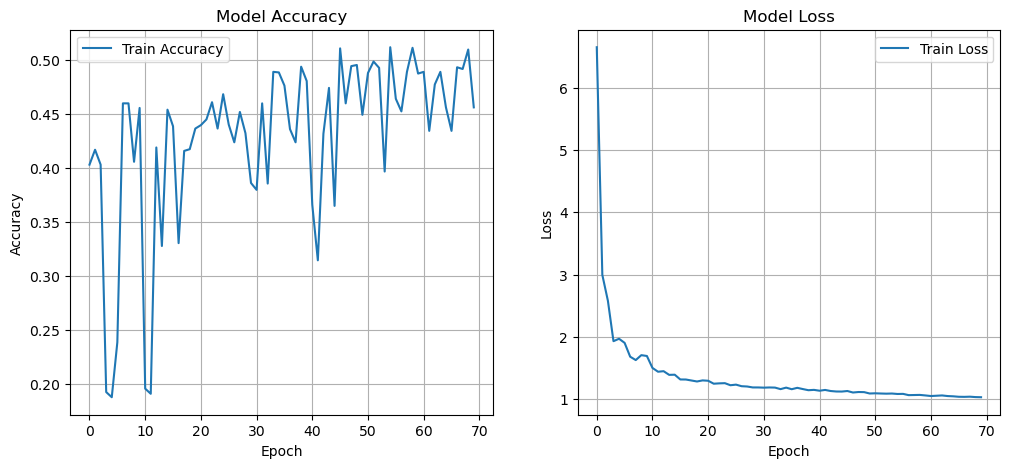

In [30]:
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['val_categorical_accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

### 3 layers

In [70]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(357,)),  # Input layer
    tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer 1
    tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer 2
    tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer 2
    tf.keras.layers.Dense(4, activation='softmax')  # Output layer for 4-class classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

checkpoint = ModelCheckpoint('multiclass_mlp_3l.h5', 
                             monitor='val_categorical_accuracy',  # Monitor validation accuracy
                             save_best_only=True, 
                             mode='max', 
                             verbose=2)

# Train the model with the checkpoint callback
history = model.fit(X, y, 
                    validation_split=0.2,
                    epochs=70, 
                    batch_size=32, 
                    callbacks=[checkpoint])

Epoch 1/70
233/236 [============================>.] - ETA: 0s - loss: 4.2000 - categorical_accuracy: 0.2949
Epoch 1: val_categorical_accuracy improved from -inf to 0.40424, saving model to multiclass_mlp_3l.h5
236/236 [==============================] - 1s 4ms/step - loss: 4.1734 - categorical_accuracy: 0.2950 - val_loss: 1.8114 - val_categorical_accuracy: 0.4042
Epoch 2/70
220/236 [==========================>...] - ETA: 0s - loss: 1.7706 - categorical_accuracy: 0.3268
Epoch 2: val_categorical_accuracy did not improve from 0.40424
236/236 [==============================] - 0s 2ms/step - loss: 1.7568 - categorical_accuracy: 0.3268 - val_loss: 1.9370 - val_categorical_accuracy: 0.2456
Epoch 3/70
211/236 [=========================>....] - ETA: 0s - loss: 1.5915 - categorical_accuracy: 0.3329
Epoch 3: val_categorical_accuracy improved from 0.40424 to 0.42759, saving model to multiclass_mlp_3l.h5
236/236 [==============================] - 0s 2ms/step - loss: 1.6118 - categorical_accuracy: 0.

37/37 [==============================] - 0s 1ms/step - loss: 1.1261 - categorical_accuracy: 0.4898
Loss: 1.1261, Accuracy: 0.4898
37/37 [==============================] - 0s 887us/step
              precision    recall  f1-score   support

     A class       0.61      0.79      0.69       399
     B class       0.39      0.35      0.37       347
     C class       0.40      0.50      0.44       278
        Fail       0.00      0.00      0.00       154

    accuracy                           0.49      1178
   macro avg       0.35      0.41      0.38      1178
weighted avg       0.42      0.49      0.45      1178



c:\Users\artkr\anaconda3\New folder\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\artkr\anaconda3\New folder\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\artkr\anaconda3\New folder\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


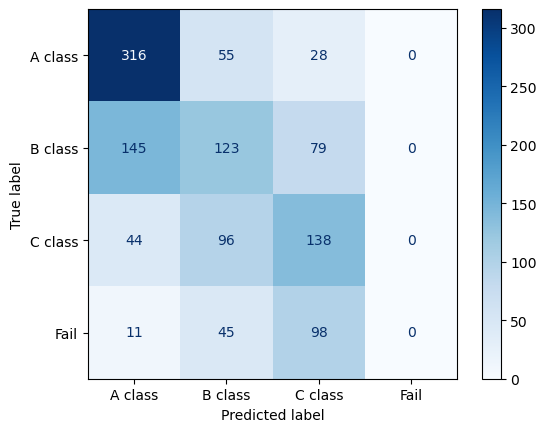

In [78]:
model = load_model('models/multiclass_mlp_128_0.1_128.h5')

loss, accuracy = model.evaluate(X_dev, y_dev, batch_size=32)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# Predict class probabilities
y_pred_probs = model.predict(X_dev)

# Convert probabilities to predicted class labels (choose the class with highest probability)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot encoded y_dev to class labels for comparison
y_dev_labels = np.argmax(y_dev, axis=1)

# Print classification report for multi-class classification
print(classification_report(y_dev_labels, y_pred, target_names=["A class", "B class", "C class", "Fail"]))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_dev_labels, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["A class", "B class", "C class", "Fail"])
disp.plot(cmap='Blues')

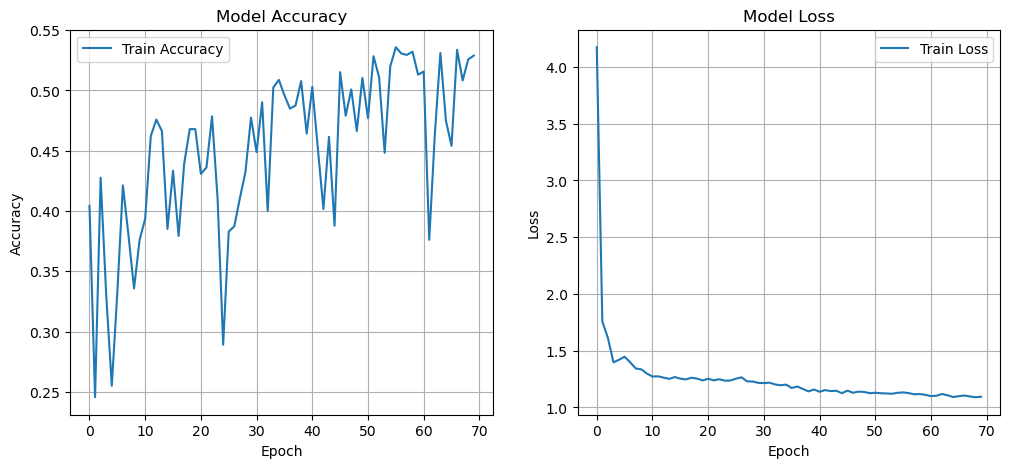

In [74]:
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['val_categorical_accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()